### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL/2_FirstImplementation

### Import libraries

In [ ]:
# Hide warnings
seed  = 42
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

### Load and process the dataset

In [ ]:
# Load data
data = np.load('../clean_data.npz', allow_pickle=True)

# Save images in a new list
images = data['data']

# Save labels in a new list
labels = data['labels']

# Print data shape
print(images.shape, labels.shape)

(5004, 96, 96, 3) (5004,)


In [ ]:
# Convert labels from string to integer
num_labels = []
for label in labels:
  if label == "healthy":
    num_labels.append(0)
  else:
    num_labels.append(1)

num_labels = np.array(num_labels)
labels = tfk.utils.to_categorical(num_labels, 2)

# Split data into train and val sets
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels,
    test_size=0.15,
    stratify=labels
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4253, 96, 96, 3), y_train shape: (4253, 2)
X_val shape: (751, 96, 96, 3), y_val shape: (751, 2)


### MobileNetV2

In [ ]:
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

### Baseline Model

In [ ]:
def build_baseline_model(mobile, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect MobileNetV2 to the input
  x = mobile(inputs)

  # Hidden layers
  x = tfkl.Dense(units=32, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=32, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='baseline_model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
baseline = build_baseline_model(mobile, 0.001)
baseline.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 256)               327936    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792     
                                                                 
 HiddenActivation2 (Activat  (None, 256)            

In [ ]:
# Train the model
history = baseline.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val)
).history

Epoch 1/200
266/266 [==============================] - 17s 23ms/step - loss: 0.5017 - accuracy: 0.7653 - val_loss: 0.4527 - val_accuracy: 0.7883
Epoch 2/200
266/266 [==============================] - 5s 18ms/step - loss: 0.3664 - accuracy: 0.8413 - val_loss: 0.4291 - val_accuracy: 0.8162
Epoch 3/200
266/266 [==============================] - 4s 14ms/step - loss: 0.2987 - accuracy: 0.8686 - val_loss: 0.3984 - val_accuracy: 0.8282
Epoch 4/200
266/266 [==============================] - 3s 11ms/step - loss: 0.2466 - accuracy: 0.8975 - val_loss: 0.4852 - val_accuracy: 0.7976
Epoch 5/200
266/266 [==============================] - 4s 15ms/step - loss: 0.1858 - accuracy: 0.9271 - val_loss: 0.5390 - val_accuracy: 0.8136
Epoch 6/200
266/266 [==============================] - 4s 14ms/step - loss: 0.1583 - accuracy: 0.9339 - val_loss: 0.5313 - val_accuracy: 0.8296
Epoch 7/200
266/266 [==============================] - 3s 11ms/step - loss: 0.1066 - accuracy: 0.9527 - val_loss: 0.7197 - val_accuracy

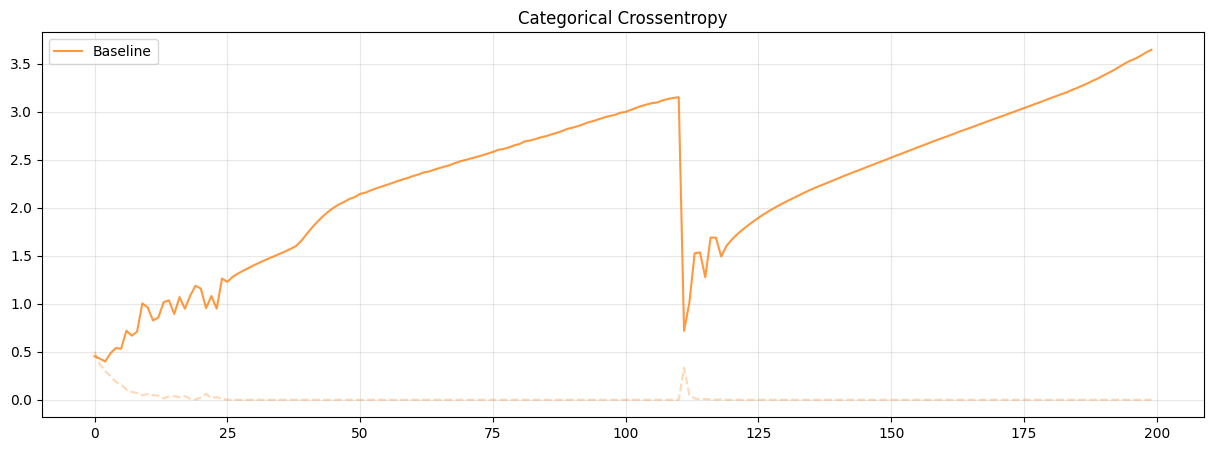

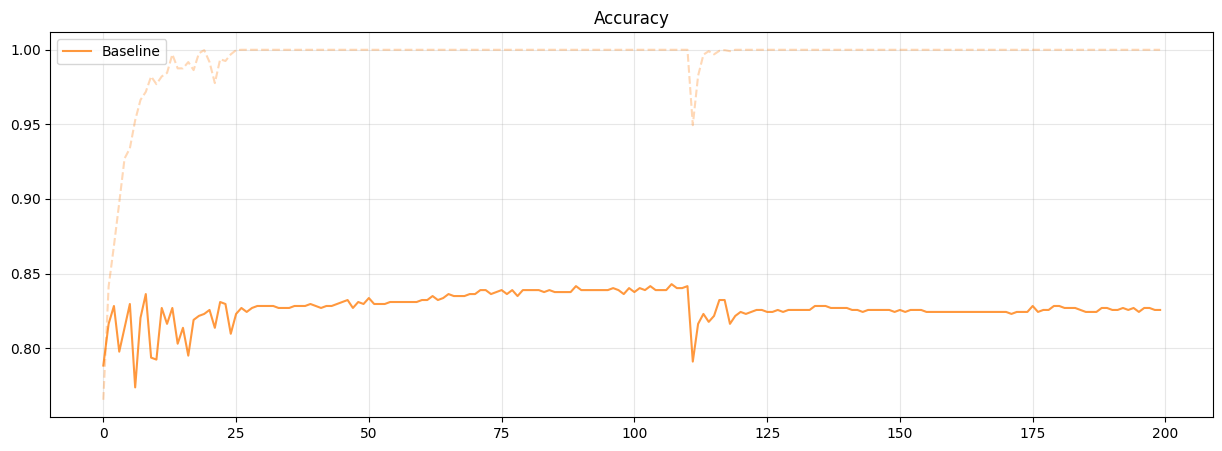

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
save = False

if save:
  baseline.save('Baseline')

### Baseline + Flipping

In [ ]:
def build_baseline_flip_model(mobile, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Set the image preprocessing
  preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal_and_vertical"),
        ], name='preprocessing')

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Preprocessing
  preprocessing = preprocessing(inputs)

  # Connect MobileNetV2 to the input
  x = mobile(preprocessing)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='flip')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
flip = build_baseline_flip_model(mobile, 0.001)
flip.summary()

Model: "flip"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 256)               327936    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792  

In [ ]:
# Train the model
history_flip = flip.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val)
).history

Epoch 1/200
266/266 [==============================] - 12s 20ms/step - loss: 0.4999 - accuracy: 0.7529 - val_loss: 0.4029 - val_accuracy: 0.8216
Epoch 2/200
266/266 [==============================] - 4s 14ms/step - loss: 0.4023 - accuracy: 0.8194 - val_loss: 0.4105 - val_accuracy: 0.8056
Epoch 3/200
266/266 [==============================] - 3s 12ms/step - loss: 0.3675 - accuracy: 0.8342 - val_loss: 0.3564 - val_accuracy: 0.8469
Epoch 4/200
266/266 [==============================] - 4s 16ms/step - loss: 0.3414 - accuracy: 0.8486 - val_loss: 0.3743 - val_accuracy: 0.8296
Epoch 5/200
266/266 [==============================] - 6s 23ms/step - loss: 0.3128 - accuracy: 0.8613 - val_loss: 0.3622 - val_accuracy: 0.8535
Epoch 6/200
266/266 [==============================] - 6s 23ms/step - loss: 0.2949 - accuracy: 0.8709 - val_loss: 0.4140 - val_accuracy: 0.8429
Epoch 7/200
266/266 [==============================] - 7s 26ms/step - loss: 0.2821 - accuracy: 0.8768 - val_loss: 0.3692 - val_accuracy

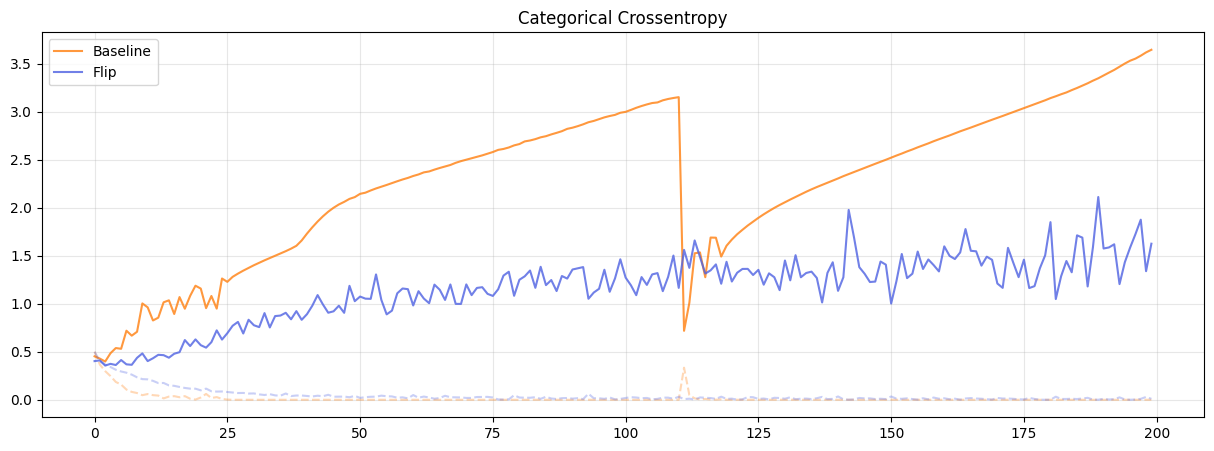

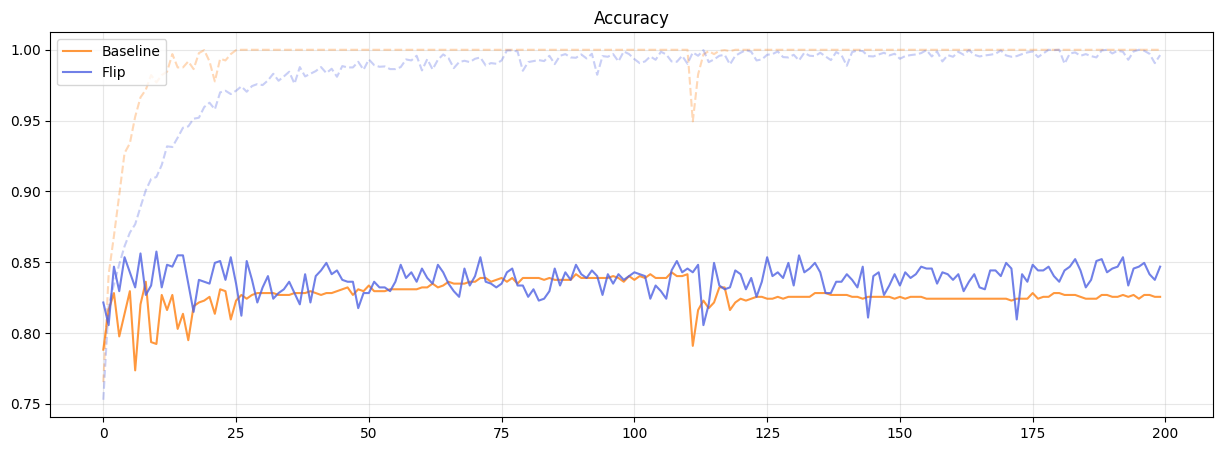

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_loss'], label='Flip', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_accuracy'], label='Flip', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
save = False

if save:
  flip.save('Flip')

### Baseline + Translation (constant)

In [ ]:
def build_baseline_transl_model(mobile, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Set the image preprocessing
  preprocessing = tf.keras.Sequential([
        tfkl.RandomTranslation(0.1,0.1, fill_mode='constant'),
        ], name='preprocessing')

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Preprocessing
  preprocessing = preprocessing(inputs)

  # Connect MobileNetV2 to the input
  x = mobile(preprocessing)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='transl')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
transl = build_baseline_transl_model(mobile, 0.001)
transl.summary()

Model: "transl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 256)               327936    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792

In [ ]:
# Train the model
history_transl = transl.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val)
).history

Epoch 1/200
266/266 [==============================] - 13s 32ms/step - loss: 0.5248 - accuracy: 0.7451 - val_loss: 0.4239 - val_accuracy: 0.8083
Epoch 2/200
266/266 [==============================] - 4s 17ms/step - loss: 0.4427 - accuracy: 0.7867 - val_loss: 0.3912 - val_accuracy: 0.8349
Epoch 3/200
266/266 [==============================] - 3s 13ms/step - loss: 0.3939 - accuracy: 0.8232 - val_loss: 0.4222 - val_accuracy: 0.8229
Epoch 4/200
266/266 [==============================] - 4s 14ms/step - loss: 0.3771 - accuracy: 0.8258 - val_loss: 0.3836 - val_accuracy: 0.8242
Epoch 5/200
266/266 [==============================] - 4s 17ms/step - loss: 0.3601 - accuracy: 0.8418 - val_loss: 0.3817 - val_accuracy: 0.8229
Epoch 6/200
266/266 [==============================] - 4s 15ms/step - loss: 0.3427 - accuracy: 0.8528 - val_loss: 0.3801 - val_accuracy: 0.8309
Epoch 7/200
266/266 [==============================] - 3s 13ms/step - loss: 0.3191 - accuracy: 0.8545 - val_loss: 0.3984 - val_accuracy

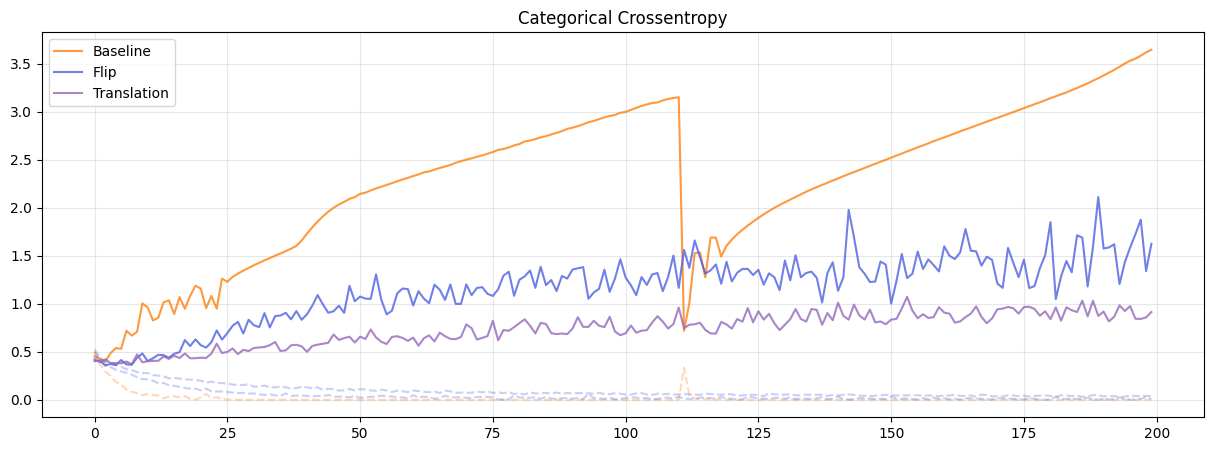

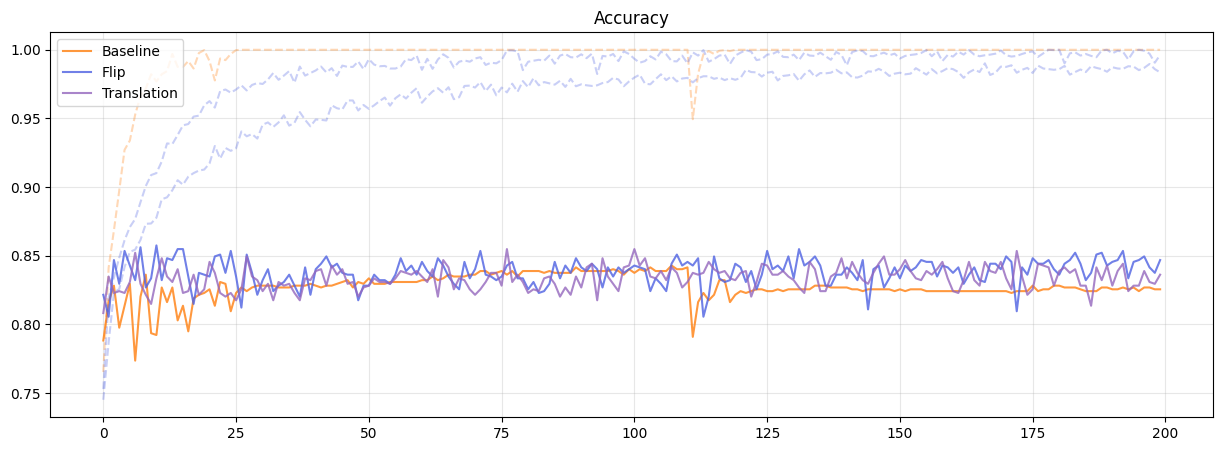

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_loss'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['loss'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_loss'], label='Translation', alpha=.8, color='#9467BD')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_accuracy'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['accuracy'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_accuracy'], label='Translation', alpha=.8, color='#9467BD')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
save = False

if save:
  transl.save('Transl')

### Baseline + Translation (constant) + Flipping

In [ ]:
def build_flip_transl_model(mobile, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Set the image preprocessing
  preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomTranslation(0.1,0.1, fill_mode='constant'),
        ], name='preprocessing')

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Preprocessing
  preprocessing = preprocessing(inputs)

  # Connect MobileNetV2 to the input
  x = mobile(preprocessing)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='flip-transl')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
flip_transl = build_flip_transl_model(mobile, 0.001)
flip_transl.summary()

Model: "flip-transl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 256)               327936    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)               

In [ ]:
# Train the model
history_flip_transl = flip_transl.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val)
).history

Epoch 1/200
266/266 [==============================] - 10s 21ms/step - loss: 0.5218 - accuracy: 0.7369 - val_loss: 0.4232 - val_accuracy: 0.8136
Epoch 2/200
266/266 [==============================] - 4s 13ms/step - loss: 0.4499 - accuracy: 0.7811 - val_loss: 0.4289 - val_accuracy: 0.8176
Epoch 3/200
266/266 [==============================] - 4s 17ms/step - loss: 0.4267 - accuracy: 0.8041 - val_loss: 0.3893 - val_accuracy: 0.8229
Epoch 4/200
266/266 [==============================] - 4s 16ms/step - loss: 0.4031 - accuracy: 0.8168 - val_loss: 0.4235 - val_accuracy: 0.8056
Epoch 5/200
266/266 [==============================] - 5s 18ms/step - loss: 0.3897 - accuracy: 0.8269 - val_loss: 0.4030 - val_accuracy: 0.8136
Epoch 6/200
266/266 [==============================] - 8s 30ms/step - loss: 0.3929 - accuracy: 0.8204 - val_loss: 0.4116 - val_accuracy: 0.8083
Epoch 7/200
266/266 [==============================] - 4s 16ms/step - loss: 0.3741 - accuracy: 0.8316 - val_loss: 0.3815 - val_accuracy

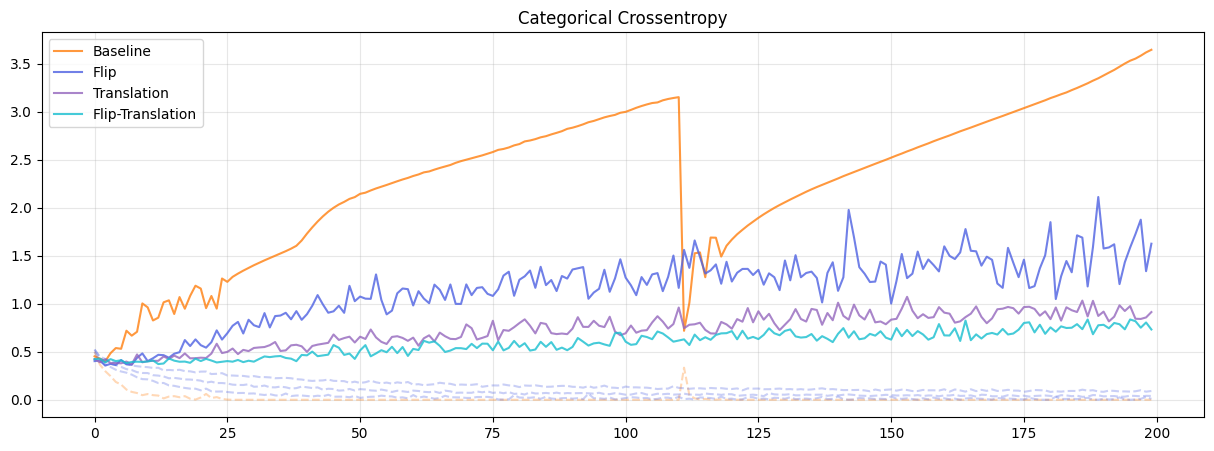

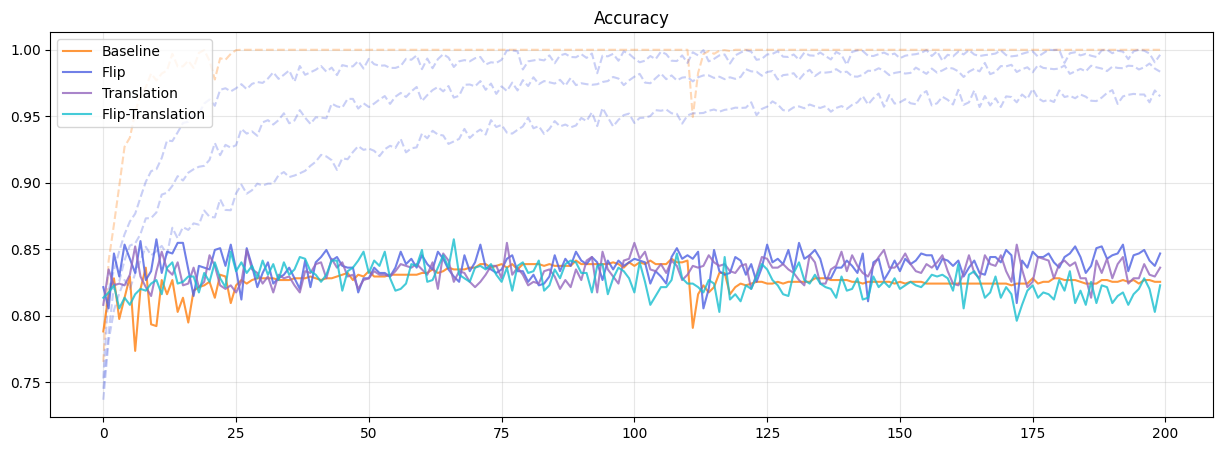

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_loss'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['loss'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_loss'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['loss'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_loss'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_accuracy'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['accuracy'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_accuracy'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['accuracy'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_accuracy'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
save = False

if save:
  flip_transl.save('FlipTransl')

### Baseline + Rotation (constant)

In [ ]:
def build_rot_model(mobile, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Set the image preprocessing
  preprocessing = tf.keras.Sequential([
        tfkl.RandomRotation(0.1, fill_mode='constant'),
        ], name='preprocessing')

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Preprocessing
  preprocessing = preprocessing(inputs)

  # Connect MobileNetV2 to the input
  x = mobile(preprocessing)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='rotation')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
rot = build_rot_model(mobile, 0.001)
rot.summary()

Model: "rotation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 256)               327936    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)               657

In [ ]:
# Train the model
history_rot = rot.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val)
).history

Epoch 1/200
266/266 [==============================] - 8s 16ms/step - loss: 0.5094 - accuracy: 0.7449 - val_loss: 0.4425 - val_accuracy: 0.8056
Epoch 2/200
266/266 [==============================] - 4s 16ms/step - loss: 0.4230 - accuracy: 0.8058 - val_loss: 0.4892 - val_accuracy: 0.7856
Epoch 3/200
266/266 [==============================] - 3s 13ms/step - loss: 0.4022 - accuracy: 0.8128 - val_loss: 0.4027 - val_accuracy: 0.8242
Epoch 4/200
266/266 [==============================] - 3s 13ms/step - loss: 0.3726 - accuracy: 0.8321 - val_loss: 0.3914 - val_accuracy: 0.8216
Epoch 5/200
266/266 [==============================] - 3s 12ms/step - loss: 0.3521 - accuracy: 0.8413 - val_loss: 0.3965 - val_accuracy: 0.8309
Epoch 6/200
266/266 [==============================] - 4s 15ms/step - loss: 0.3409 - accuracy: 0.8483 - val_loss: 0.5172 - val_accuracy: 0.7790
Epoch 7/200
266/266 [==============================] - 3s 12ms/step - loss: 0.3213 - accuracy: 0.8563 - val_loss: 0.4134 - val_accuracy:

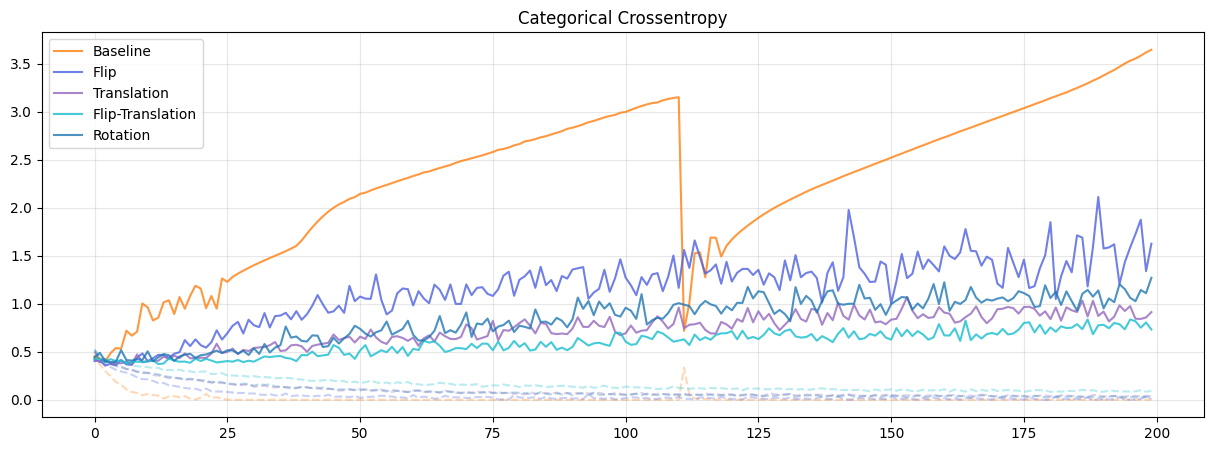

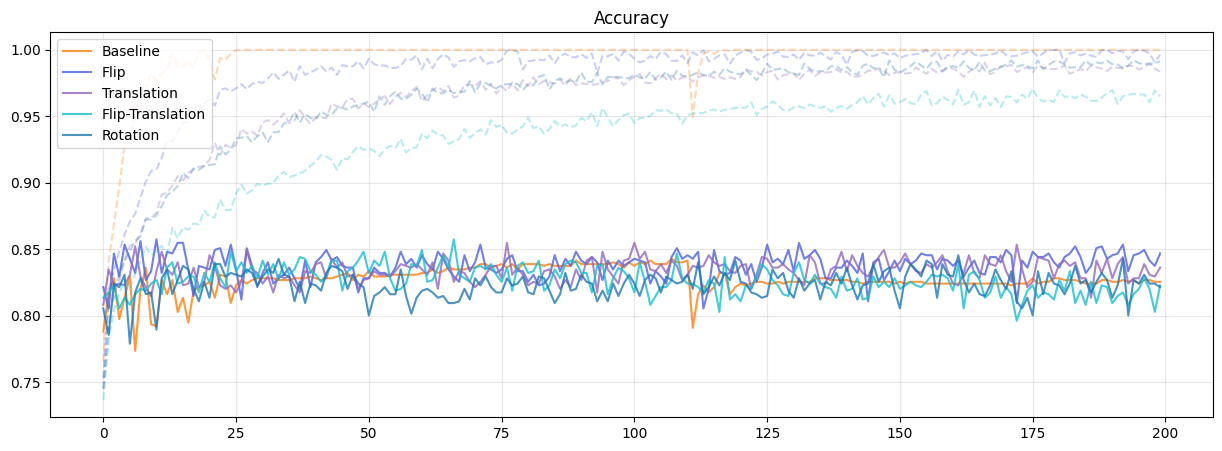

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_loss'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['loss'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_loss'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['loss'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_loss'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.plot(history_rot['loss'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_rot['val_loss'], label='Rotation', alpha=.8, color='#1f77b4')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_accuracy'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['accuracy'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_accuracy'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['accuracy'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_accuracy'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.plot(history_rot['accuracy'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_rot['val_accuracy'], label='Rotation', alpha=.8, color='#1f77b4')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
save = False

if save:
  rot.save('Rotation')

### Baseline + Flipping + Rotation

In [ ]:
def build_flip_rot_model(mobile, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Set the image preprocessing
  preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomRotation(0.1, fill_mode='constant'),
        ], name='preprocessing')

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Preprocessing
  preprocessing = preprocessing(inputs)

  # Connect MobileNetV2 to the input
  x = mobile(preprocessing)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='flip-rotation')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
flip_rot = build_flip_rot_model(mobile, 0.001)
flip_rot.summary()

Model: "flip-rotation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 256)               327936    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)             

In [ ]:
# Train the model
history_flip_rot = flip_rot.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val)
).history

Epoch 1/200
266/266 [==============================] - 9s 17ms/step - loss: 0.5207 - accuracy: 0.7486 - val_loss: 0.4514 - val_accuracy: 0.7870
Epoch 2/200
266/266 [==============================] - 4s 13ms/step - loss: 0.4370 - accuracy: 0.7950 - val_loss: 0.4336 - val_accuracy: 0.7856
Epoch 3/200
266/266 [==============================] - 5s 17ms/step - loss: 0.4299 - accuracy: 0.7957 - val_loss: 0.3955 - val_accuracy: 0.8402
Epoch 4/200
266/266 [==============================] - 4s 14ms/step - loss: 0.4013 - accuracy: 0.8091 - val_loss: 0.4051 - val_accuracy: 0.8056
Epoch 5/200
266/266 [==============================] - 3s 13ms/step - loss: 0.3963 - accuracy: 0.8185 - val_loss: 0.3958 - val_accuracy: 0.8242
Epoch 6/200
266/266 [==============================] - 4s 16ms/step - loss: 0.3756 - accuracy: 0.8319 - val_loss: 0.3862 - val_accuracy: 0.8309
Epoch 7/200
266/266 [==============================] - 4s 13ms/step - loss: 0.3703 - accuracy: 0.8302 - val_loss: 0.4258 - val_accuracy:

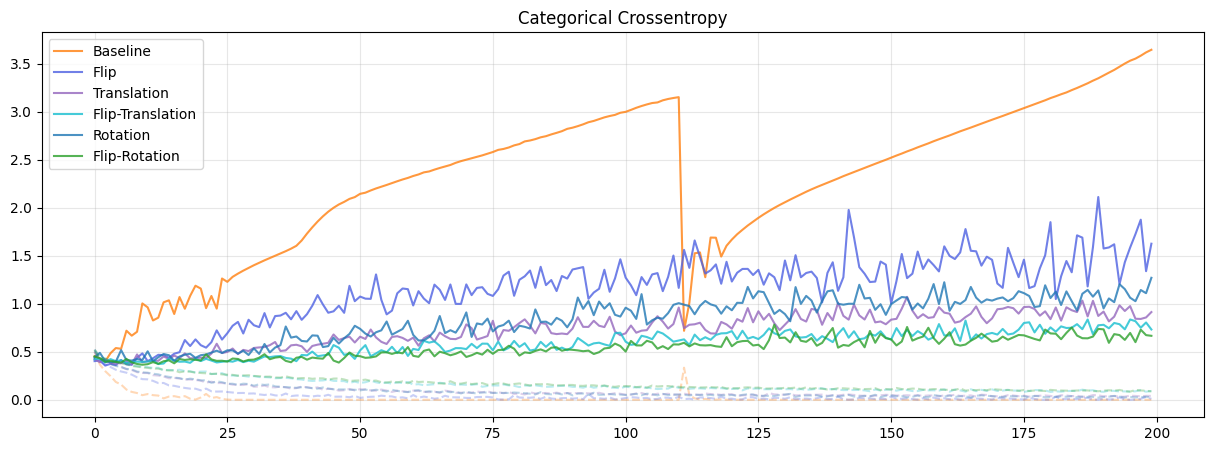

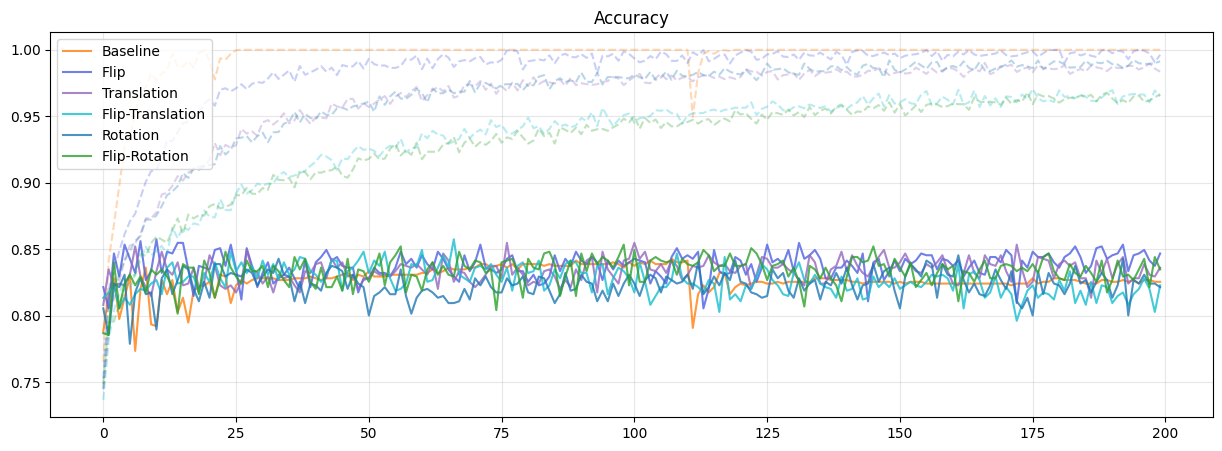

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_loss'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['loss'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_loss'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['loss'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_loss'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.plot(history_rot['loss'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_rot['val_loss'], label='Rotation', alpha=.8, color='#1f77b4')
plt.plot(history_flip_rot['loss'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history_flip_rot['val_loss'], label='Flip-Rotation', alpha=.8, color='#2ca02c')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_accuracy'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['accuracy'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_accuracy'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['accuracy'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_accuracy'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.plot(history_rot['accuracy'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_rot['val_accuracy'], label='Rotation', alpha=.8, color='#1f77b4')
plt.plot(history_flip_rot['accuracy'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history_flip_rot['val_accuracy'], label='Flip-Rotation', alpha=.8, color='#2ca02c')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
save = False

if save:
  flip_rot.save('FlipRotation')

### Baseline + Flip + Rotation + Translation

In [ ]:
def build_flip_rot_transl_model(mobile, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Set the image preprocessing
  preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomRotation(0.1, fill_mode='constant'),
        tfkl.RandomTranslation(0.1,0.1, fill_mode='constant'),
        ], name='preprocessing')

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Preprocessing
  preprocessing = preprocessing(inputs)

  # Connect MobileNetV2 to the input
  x = mobile(preprocessing)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='flip-rot-transl')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
flip_rot_transl = build_flip_rot_transl_model(mobile, 0.001)
flip_rot_transl.summary()

Model: "flip-rot-transl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 256)               327936    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)           

In [ ]:
# Train the model
history_flip_rot_transl = flip_rot_transl.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val)
).history

Epoch 1/200
266/266 [==============================] - 10s 19ms/step - loss: 0.5471 - accuracy: 0.7228 - val_loss: 0.4603 - val_accuracy: 0.7630
Epoch 2/200
266/266 [==============================] - 4s 14ms/step - loss: 0.4835 - accuracy: 0.7675 - val_loss: 0.4468 - val_accuracy: 0.7989
Epoch 3/200
266/266 [==============================] - 5s 17ms/step - loss: 0.4482 - accuracy: 0.7945 - val_loss: 0.4158 - val_accuracy: 0.8056
Epoch 4/200
266/266 [==============================] - 4s 14ms/step - loss: 0.4379 - accuracy: 0.7940 - val_loss: 0.4171 - val_accuracy: 0.8069
Epoch 5/200
266/266 [==============================] - 4s 13ms/step - loss: 0.4242 - accuracy: 0.8058 - val_loss: 0.4326 - val_accuracy: 0.8216
Epoch 6/200
266/266 [==============================] - 4s 15ms/step - loss: 0.4119 - accuracy: 0.8126 - val_loss: 0.4850 - val_accuracy: 0.7750
Epoch 7/200
266/266 [==============================] - 4s 16ms/step - loss: 0.4085 - accuracy: 0.8105 - val_loss: 0.3938 - val_accuracy

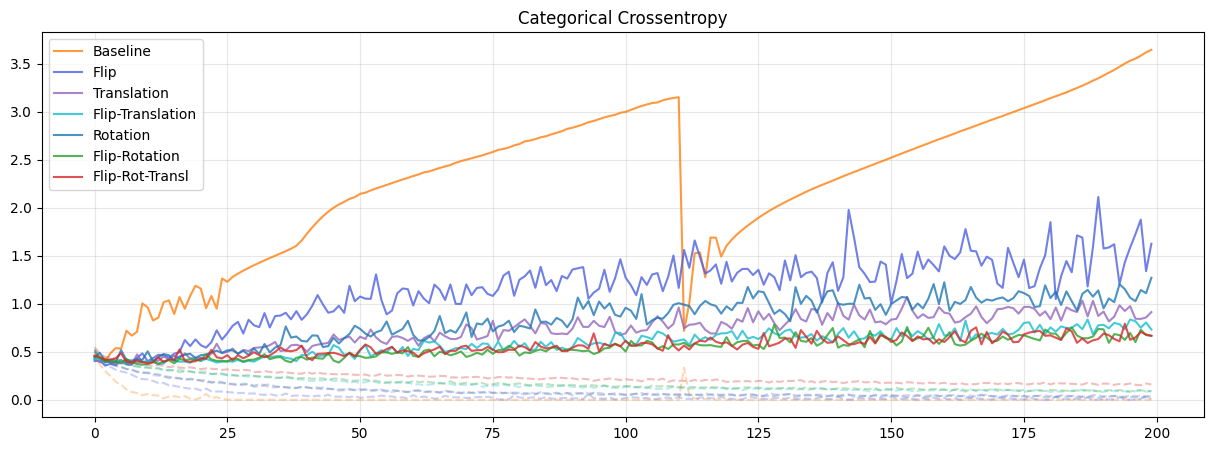

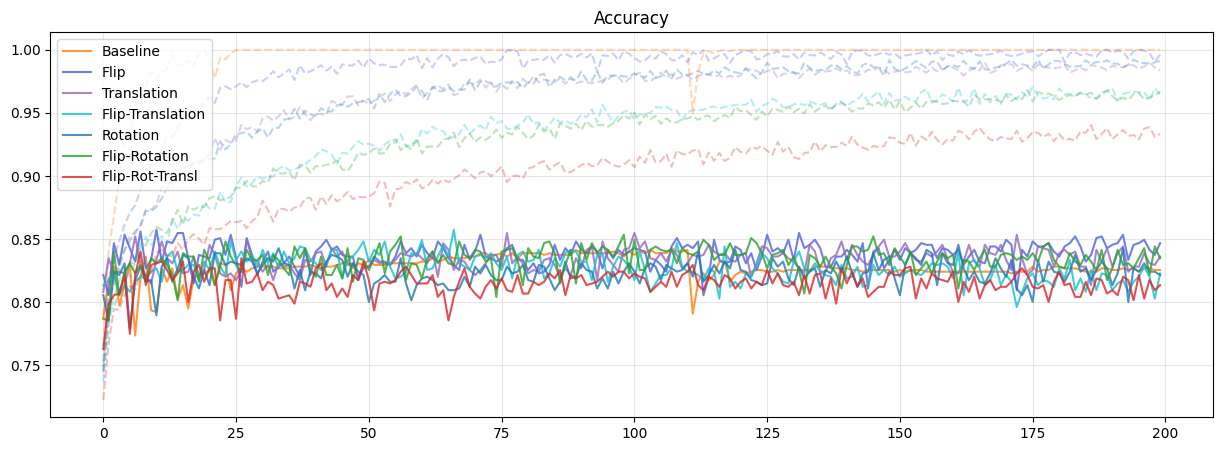

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_loss'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['loss'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_loss'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['loss'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_loss'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.plot(history_rot['loss'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_rot['val_loss'], label='Rotation', alpha=.8, color='#1f77b4')
plt.plot(history_flip_rot['loss'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history_flip_rot['val_loss'], label='Flip-Rotation', alpha=.8, color='#2ca02c')
plt.plot(history_flip_rot_transl['loss'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history_flip_rot_transl['val_loss'], label='Flip-Rot-Transl', alpha=.8, color='#d62728')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_accuracy'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['accuracy'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_accuracy'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['accuracy'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_accuracy'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.plot(history_rot['accuracy'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_rot['val_accuracy'], label='Rotation', alpha=.8, color='#1f77b4')
plt.plot(history_flip_rot['accuracy'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history_flip_rot['val_accuracy'], label='Flip-Rotation', alpha=.8, color='#2ca02c')
plt.plot(history_flip_rot_transl['accuracy'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history_flip_rot_transl['val_accuracy'], label='Flip-Rot-Transl', alpha=.8, color='#d62728')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
save = False

if save:
  flip_rot_transl.save('FlipRotTransl')

### Baseline + Brightness

In [ ]:
def build_bright_model(mobile, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Set the image preprocessing
  preprocessing = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(0,1)),
        ], name='preprocessing')

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Preprocessing
  preprocessing = preprocessing(inputs)

  # Connect MobileNetV2 to the input
  x = mobile(preprocessing)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='brightness')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
bright = build_bright_model(mobile, 0.001)
bright.summary()

Model: "brightness"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 256)               327936    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)               6

In [ ]:
# Train the model
history_bright = bright.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val)
).history

Epoch 1/200
266/266 [==============================] - 9s 19ms/step - loss: 0.5546 - accuracy: 0.7204 - val_loss: 0.6778 - val_accuracy: 0.6778
Epoch 2/200
266/266 [==============================] - 4s 14ms/step - loss: 0.4602 - accuracy: 0.7832 - val_loss: 0.5032 - val_accuracy: 0.7683
Epoch 3/200
266/266 [==============================] - 3s 12ms/step - loss: 0.4231 - accuracy: 0.7987 - val_loss: 0.5158 - val_accuracy: 0.7696
Epoch 4/200
266/266 [==============================] - 3s 13ms/step - loss: 0.3891 - accuracy: 0.8211 - val_loss: 0.5947 - val_accuracy: 0.7457
Epoch 5/200
266/266 [==============================] - 4s 15ms/step - loss: 0.3535 - accuracy: 0.8446 - val_loss: 0.6736 - val_accuracy: 0.7364
Epoch 6/200
266/266 [==============================] - 3s 12ms/step - loss: 0.3270 - accuracy: 0.8547 - val_loss: 0.6807 - val_accuracy: 0.7430
Epoch 7/200
266/266 [==============================] - 3s 12ms/step - loss: 0.3075 - accuracy: 0.8695 - val_loss: 0.7469 - val_accuracy:

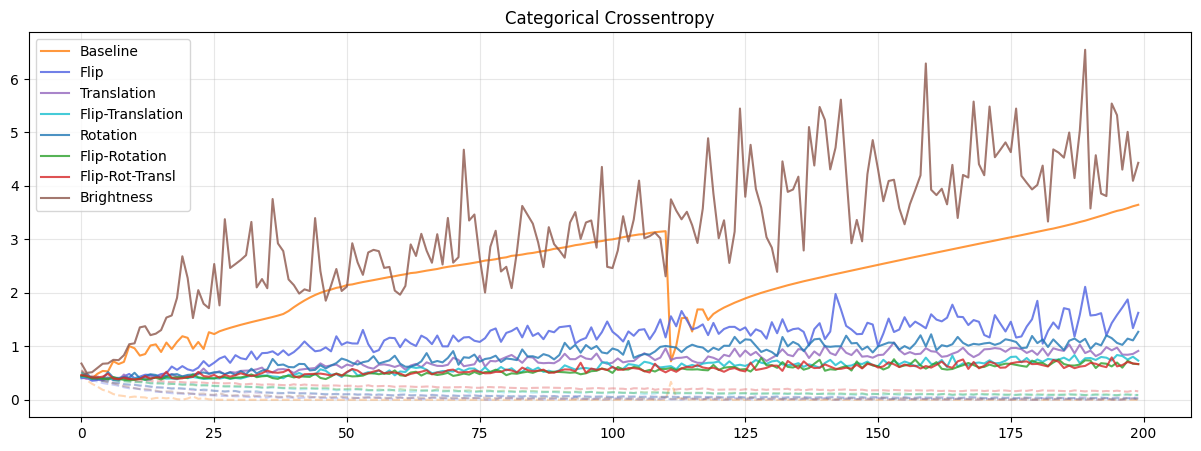

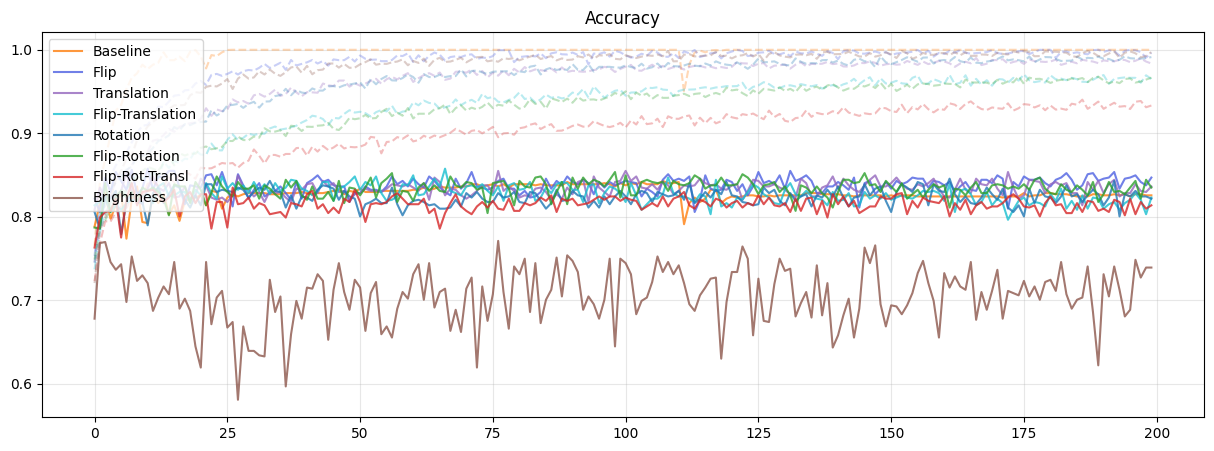

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_loss'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['loss'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_loss'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['loss'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_loss'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.plot(history_rot['loss'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_rot['val_loss'], label='Rotation', alpha=.8, color='#1f77b4')
plt.plot(history_flip_rot['loss'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history_flip_rot['val_loss'], label='Flip-Rotation', alpha=.8, color='#2ca02c')
plt.plot(history_flip_rot_transl['loss'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history_flip_rot_transl['val_loss'], label='Flip-Rot-Transl', alpha=.8, color='#d62728')
plt.plot(history_bright['loss'], alpha=.3, color='#8c564b', linestyle='--')
plt.plot(history_bright['val_loss'], label='Brightness', alpha=.8, color='#8c564b')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_accuracy'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['accuracy'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_accuracy'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['accuracy'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_accuracy'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.plot(history_rot['accuracy'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_rot['val_accuracy'], label='Rotation', alpha=.8, color='#1f77b4')
plt.plot(history_flip_rot['accuracy'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history_flip_rot['val_accuracy'], label='Flip-Rotation', alpha=.8, color='#2ca02c')
plt.plot(history_flip_rot_transl['accuracy'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history_flip_rot_transl['val_accuracy'], label='Flip-Rot-Transl', alpha=.8, color='#d62728')
plt.plot(history_bright['accuracy'], alpha=.3, color='#8c564b', linestyle='--')
plt.plot(history_bright['val_accuracy'], label='Brightness', alpha=.8, color='#8c564b')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
save = False

if save:
  bright.save('Brightness')

### Baseline + Contrast

In [ ]:
def build_contrast_model(mobile, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Set the image preprocessing
  preprocessing = tf.keras.Sequential([
        tfkl.RandomContrast(0.1),
        ], name='preprocessing')

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Preprocessing
  preprocessing = preprocessing(inputs)

  # Connect MobileNetV2 to the input
  x = mobile(preprocessing)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='contrast')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
contrast = build_contrast_model(mobile, 0.001)
contrast.summary()

Model: "contrast"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 256)               327936    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)               657

In [ ]:
# Train the model
history_contrast = contrast.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val)
).history

Epoch 1/200
266/266 [==============================] - 8s 19ms/step - loss: 0.5495 - accuracy: 0.7315 - val_loss: 0.5580 - val_accuracy: 0.7124
Epoch 2/200
266/266 [==============================] - 3s 13ms/step - loss: 0.4339 - accuracy: 0.7980 - val_loss: 0.4862 - val_accuracy: 0.7710
Epoch 3/200
266/266 [==============================] - 4s 15ms/step - loss: 0.3833 - accuracy: 0.8232 - val_loss: 0.6282 - val_accuracy: 0.6951
Epoch 4/200
266/266 [==============================] - 3s 11ms/step - loss: 0.3186 - accuracy: 0.8559 - val_loss: 0.7317 - val_accuracy: 0.6964
Epoch 5/200
266/266 [==============================] - 3s 12ms/step - loss: 0.2878 - accuracy: 0.8808 - val_loss: 0.7859 - val_accuracy: 0.6778
Epoch 6/200
266/266 [==============================] - 4s 13ms/step - loss: 0.2256 - accuracy: 0.9074 - val_loss: 1.1101 - val_accuracy: 0.6698
Epoch 7/200
266/266 [==============================] - 4s 14ms/step - loss: 0.1892 - accuracy: 0.9210 - val_loss: 1.1809 - val_accuracy:

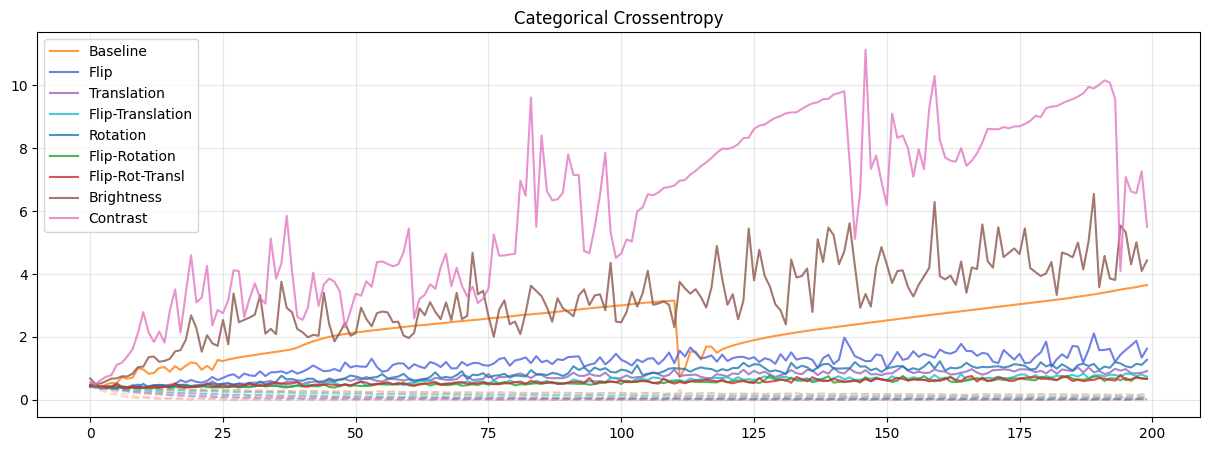

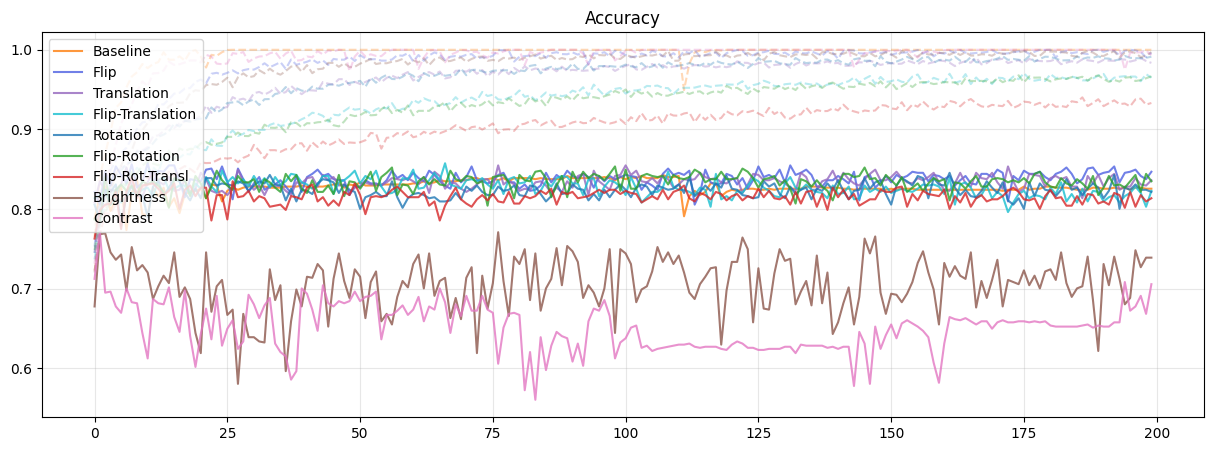

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_loss'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['loss'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_loss'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['loss'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_loss'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.plot(history_rot['loss'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_rot['val_loss'], label='Rotation', alpha=.8, color='#1f77b4')
plt.plot(history_flip_rot['loss'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history_flip_rot['val_loss'], label='Flip-Rotation', alpha=.8, color='#2ca02c')
plt.plot(history_flip_rot_transl['loss'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history_flip_rot_transl['val_loss'], label='Flip-Rot-Transl', alpha=.8, color='#d62728')
plt.plot(history_bright['loss'], alpha=.3, color='#8c564b', linestyle='--')
plt.plot(history_bright['val_loss'], label='Brightness', alpha=.8, color='#8c564b')
plt.plot(history_contrast['loss'], alpha=.3, color='#e377c2', linestyle='--')
plt.plot(history_contrast['val_loss'], label='Contrast', alpha=.8, color='#e377c2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_accuracy'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['accuracy'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_accuracy'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['accuracy'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_accuracy'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.plot(history_rot['accuracy'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_rot['val_accuracy'], label='Rotation', alpha=.8, color='#1f77b4')
plt.plot(history_flip_rot['accuracy'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history_flip_rot['val_accuracy'], label='Flip-Rotation', alpha=.8, color='#2ca02c')
plt.plot(history_flip_rot_transl['accuracy'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history_flip_rot_transl['val_accuracy'], label='Flip-Rot-Transl', alpha=.8, color='#d62728')
plt.plot(history_bright['accuracy'], alpha=.3, color='#8c564b', linestyle='--')
plt.plot(history_bright['val_accuracy'], label='Brightness', alpha=.8, color='#8c564b')
plt.plot(history_contrast['accuracy'], alpha=.3, color='#e377c2', linestyle='--')
plt.plot(history_contrast['val_accuracy'], label='Contrast', alpha=.8, color='#e377c2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
save = False

if save:
  contrast.save('Contrast')

### Baseline + Zoom

In [ ]:
def build_zoom_model(mobile, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  mobile.trainable = False

  # Set the image preprocessing
  preprocessing = tf.keras.Sequential([
        tfkl.RandomZoom(0.05),
        ], name='preprocessing')

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Preprocessing
  preprocessing = preprocessing(inputs)

  # Connect MobileNetV2 to the input
  x = mobile(preprocessing)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='zoom')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
zoom = build_zoom_model(mobile, 0.001)
zoom.summary()

Model: "zoom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 HiddenDense1 (Dense)        (None, 256)               327936    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792  

In [ ]:
# Train the model
history_zoom = zoom.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val)
).history

Epoch 1/200
266/266 [==============================] - 8s 16ms/step - loss: 0.4902 - accuracy: 0.7722 - val_loss: 0.4187 - val_accuracy: 0.8043
Epoch 2/200
266/266 [==============================] - 3s 13ms/step - loss: 0.3834 - accuracy: 0.8265 - val_loss: 0.4103 - val_accuracy: 0.8149
Epoch 3/200
266/266 [==============================] - 4s 15ms/step - loss: 0.3355 - accuracy: 0.8476 - val_loss: 0.3861 - val_accuracy: 0.8349
Epoch 4/200
266/266 [==============================] - 4s 13ms/step - loss: 0.3031 - accuracy: 0.8648 - val_loss: 0.4520 - val_accuracy: 0.7976
Epoch 5/200
266/266 [==============================] - 3s 12ms/step - loss: 0.2710 - accuracy: 0.8834 - val_loss: 0.4387 - val_accuracy: 0.8216
Epoch 6/200
266/266 [==============================] - 3s 13ms/step - loss: 0.2349 - accuracy: 0.8982 - val_loss: 0.4501 - val_accuracy: 0.8309
Epoch 7/200
266/266 [==============================] - 4s 14ms/step - loss: 0.2042 - accuracy: 0.9104 - val_loss: 0.4614 - val_accuracy:

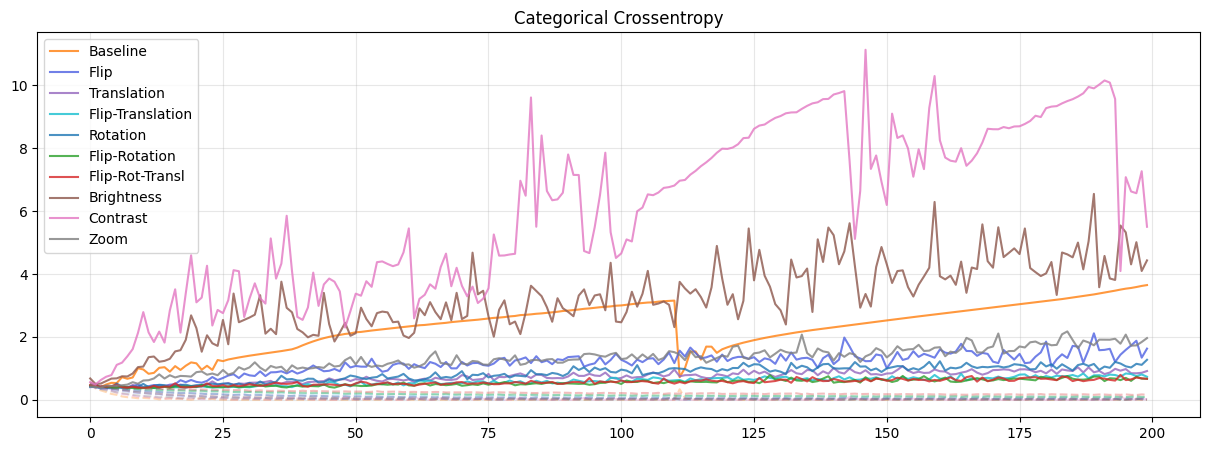

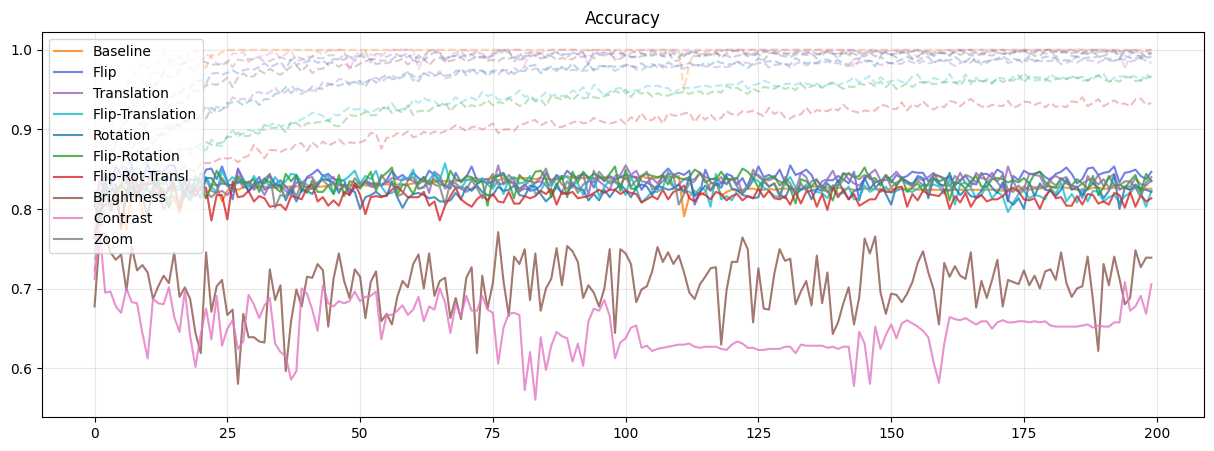

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_loss'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['loss'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_loss'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['loss'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_loss'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.plot(history_rot['loss'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_rot['val_loss'], label='Rotation', alpha=.8, color='#1f77b4')
plt.plot(history_flip_rot['loss'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history_flip_rot['val_loss'], label='Flip-Rotation', alpha=.8, color='#2ca02c')
plt.plot(history_flip_rot_transl['loss'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history_flip_rot_transl['val_loss'], label='Flip-Rot-Transl', alpha=.8, color='#d62728')
plt.plot(history_bright['loss'], alpha=.3, color='#8c564b', linestyle='--')
plt.plot(history_bright['val_loss'], label='Brightness', alpha=.8, color='#8c564b')
plt.plot(history_contrast['loss'], alpha=.3, color='#e377c2', linestyle='--')
plt.plot(history_contrast['val_loss'], label='Contrast', alpha=.8, color='#e377c2')
plt.plot(history_zoom['loss'], alpha=.3, color='#7f7f7f', linestyle='--')
plt.plot(history_zoom['val_loss'], label='Zoom', alpha=.8, color='#7f7f7f')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_accuracy'], label='Flip', alpha=.8, color='#4D61E2')
plt.plot(history_transl['accuracy'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_transl['val_accuracy'], label='Translation', alpha=.8, color='#9467BD')
plt.plot(history_flip_transl['accuracy'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_flip_transl['val_accuracy'], label='Flip-Translation', alpha=.8, color='#17BECF')
plt.plot(history_rot['accuracy'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_rot['val_accuracy'], label='Rotation', alpha=.8, color='#1f77b4')
plt.plot(history_flip_rot['accuracy'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history_flip_rot['val_accuracy'], label='Flip-Rotation', alpha=.8, color='#2ca02c')
plt.plot(history_flip_rot_transl['accuracy'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history_flip_rot_transl['val_accuracy'], label='Flip-Rot-Transl', alpha=.8, color='#d62728')
plt.plot(history_bright['accuracy'], alpha=.3, color='#8c564b', linestyle='--')
plt.plot(history_bright['val_accuracy'], label='Brightness', alpha=.8, color='#8c564b')
plt.plot(history_contrast['accuracy'], alpha=.3, color='#e377c2', linestyle='--')
plt.plot(history_contrast['val_accuracy'], label='Contrast', alpha=.8, color='#e377c2')
plt.plot(history_zoom['accuracy'], alpha=.3, color='#7f7f7f', linestyle='--')
plt.plot(history_zoom['val_accuracy'], label='Zoom', alpha=.8, color='#7f7f7f')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
save = False

if save:
  zoom.save('Zoom')